# Week 8: Quantifying your perceptual experience of an illusory shape

In our replication of Ringach and Shapley, we measured psychometric functions for discriminating "fat" from "thin" shapes (or in the control condition, "clockwise" from "counterclockwise" rotations). This is a "yes-no" task (single-interval, two response alternative) in which you were presented with a single stimulus and you classified it into one of two classes.

## The data set

You should have downloaded and extracted the data zip file into your `data` directory. 
There should be three files:

- `wahrnehmen_2024_master_data_preprocessed.csv`: contains the raw trial data after preprocessing.
- `wahrnehmen_psy_func_params.csv`: contains a row for each participant, with the maximum likelihood parameter estimates for that participant plus curve fit values.
- `wahrnehmen_psy_func_curves.csv`: the same information as in `func_params` with curve fits, but re-arranged into a long-format dataframe. 

## Preprocessing

We pre-processed the dataset by 

1. Excluding anyone who used a non-anonymised participant code
2. Excluding people who did not collect the requested 2400 trials
3. Excluding cases with missing data

This resulted in a final set of 70 participants' data, with a total of 233.280 trials.

## Psychometric functions 

We have fit a psychometric function to your data. Below, we provide a bit more detail and have an interactive widget to let you play with psychometric functions, to see what the parameters do.

In [2]:
%%capture
# check that we have the more unusual packages available:
!pip install ipywidgets

In [3]:
import numpy as np
import pandas as pd
from ipywidgets import *
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
# set matplotlib style
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
# plt.style.use('seaborn-whitegrid')

from helpers.notebook_helper_functions import (
    get_top_directory,
    plot_gaussian,
)

from helpers.psychometric_function import (
    PsychometricFunction,
    summarize_data,
    do_fitting,
    do_curve_data,
)

top_directory = get_top_directory()

# make sure we have somewhere to save the figure outputs:
if not (top_directory / "figures").exists():
    (top_directory / "figures").mkdir()

%load_ext autoreload
%autoreload 2


## Part I: The psychometric function

To quantify how your probability of responding "clockwise" changes as a function of the stimulus orientation, we can fit a **psychometric function** to your data. We make some assumptions about how your performance changes, then use your data to estimate the specific parameters of the function that "best fit" the data. 

In our experiment, you were presented with one stimulus and asked to classify it as one of two options (either "fat" or "thin", "clockwise" or "counterclockwise" depending on the condition).
On each trial, we assume that the participant experiences some evidence for the shape being either thin or fat. 
We assume that this evidence is related to the rotation angle of the pacmen.

This type of task is sometimes called a "yes-no" task, or a "single-interval, two response alternative" task. 
The "yes-no" psychometric function describes how the probability of choosing one of the alternatives changes as a function of the stimulus value. Because there are only two possible responses, we can think of this probability as one-dimensional -- the probability of responding with "option 1", which runs between zero and one. (Correspondingly, the probability of responding with "option 2" is one minus the first probability).

In our case, the psychometric function describes the proportion of "clockwise"/"thin" responses as arising from a sigmoidal function (a "sigmoidal function" is any function that's "S"-shaped) that runs from zero (never responded "clockwise") to one (always responded "clockwise"). 

Here we will use the cumulative normal distribution function ($\Phi$) as our sigmoidal function. This is a common choice; other common choices are the logistic function and the cumulative Weibull function. In practice, this choice tends to make little difference to the outcome if you're mainly interested in threshold and JND.


### The Normal distribution

The Normal or Gaussian distribution is one of the most commonly-used probability distributions. 


For this course, you do not need to write functions defining these distributions yourself. 
You can use the ones defined by the `scipy` package, imported above into the namespace `norm`.
Below you can see how to use `norm`:


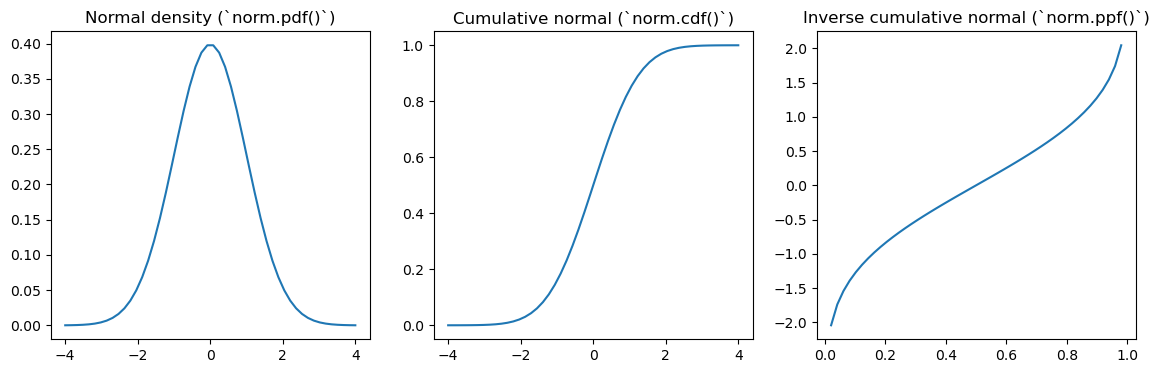

In [4]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

plot_gaussian()

The cumulative normal function has two parameters, mean $\mu$ and standard deviation $\sigma$, where $x$ below represents the angle offset of the stimulus:

$$p(\mathrm{r = fat} | x; \mu, \sigma) = \Phi(x; \mu, \sigma)  $$

Convince yourself that values of $\mu$ and $\sigma$ are here in units of orientation (degrees).

### The psychometric function with lapses

Chances are good that your data for large angle offsets aren't exactly zero or exactly one. There's a chance that you will accidentally press the wrong button even though you can easily judge the orientation offsets of these stimuli in general. 
You may not attend, blink, or maybe even have a microsleep during a trial.
These stimulus-independent button presses are called *lapses*. 

Lapses can affect the estimates of $\mu$ and $\sigma$, so they should be taken into account in our psychometric function fit. We can do so using a third parameter, here denoted with $\kappa$ ("kappa"). Note that this parameter is usually referred to as $\lambda$ but I've changed it here to avoid confusion with the criterion in the equal-variance Gaussian SDT model (also $\lambda$). We can use $\kappa$ to "squish" the sigmoid so that it no longer asymptotes at zero and one, but instead at $0 + \kappa$ and $1 - \kappa$. Here, we have assumed that your lapse rates are symmetric: you're equally likely to lapse when the angle offset is clockwise or counterclockwise (IC stimulus is thin or fat).

$$p(\mathrm{r = fat} | x; \mu, \sigma, \kappa) = \kappa + (1 - 2\kappa)\Phi(x; \mu, \sigma)  $$

So, our yes-no psychometric function with lapses now has three free parameters: mean $\mu$, standard deviation $\sigma$, and lapse rate $\kappa$. Note that because $\kappa$ is the lower asymptote and $1-\kappa$ is the upper asymptote, the *total* proportion of lapses is $2\kappa$.

### Visualising the psychometric function

You can use the cell below to visualise what a particular psychometric function looks like. 
Change the $\mu$, $\sigma$ and $\kappa$ parameters in the function call to see what effect this has.

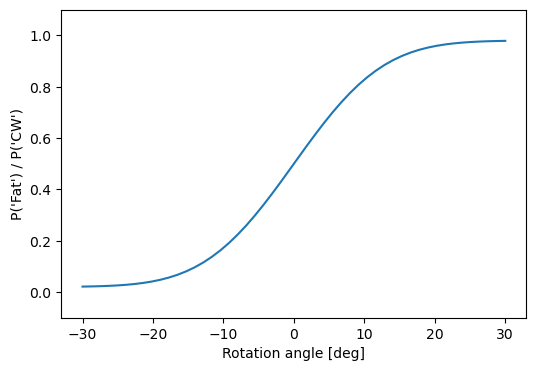

In [5]:
# visualise the psychometric function
psy_func = PsychometricFunction()
psy_func.plot_psy_function(mu=0.0, sigma=10.0, kappa=0.02)

You can also try adjusting the parameters and observing the effects using the interactive plot below:

In [6]:
psy_func.plot_interactive_psy_function()  # hopefully this works across different versions!

interactive(children=(FloatSlider(value=0.0, description='mu', max=3.0, min=-3.0, step=0.2), FloatSlider(value…

### <span style="color:blue">Further thinking</span>

In the context of our experiment, what is the meaning of the $\mu$ and $\sigma$ parameters? 
What does it mean if $\mu$ is zero? What does it mean if $\mu$ is positive or negative?
What does it mean if $\sigma$ is larger or smaller?

Think about the answers to these questions yourself and discuss with your fellow students.

### The Just-Noticable-Difference (JND)

Recall that the purpose of our experiment is to compare the difficulty of discriminating the rotation angle when it's part of an Illusory Contour (IC condition) or only in a local orientation configuration (LO control).

The typical measure of discrimination performance for a yes-no psychometric function is called the Just-Noticeable-Difference (JND). The JND is the rotation angle you need to judge the shape to some defined level of performance.
By convention, it is typical to define JND as half the difference between the stimulus intensities yielding the 25% and 75% percentiles on the cumulative psychometric function (i.e. symmetric in quantile around $\mu$), which is what we will use here.
In other words:

$$\mathrm{JND} = \frac{\Phi^{-1}(0.75; \mu, \sigma) - \Phi^{-1}(0.25; \mu, \sigma)}{2}$$

In this case, the JND is fully determined by the fitted $\sigma$, and is in units of degrees.
Note also that in this case, the JND is symmetric -- so we could compute it as the difference between the 75th and 50th percentile (and we could ignore $\mu$) and it would be the same value. 
But in cases where we have asymmetric psychometric functions, the 75-25 percentile definition is preferred.

In [7]:
PsychometricFunction().plot_interactive_psy_function(annotations=True)

interactive(children=(FloatSlider(value=0.0, description='mu', max=3.0, min=-3.0, step=0.2), FloatSlider(value…

**Is this the same analysis as Ringach and Shapley?**

No. 
Ringach and Shapley compute *accuracy* (proportion of correct responses) collapsed over absolute rotation angle.
Note how the lower asymptote of their psychometric function is 0.5, not 0 as in ours.
They use "threshold" as their measure of discrimination performance, defined as the absolute angle that produces 75% correct reports. 
This measure is ultimately very similar to our JND measure. 
Why we do a different analysis will become clear in the weeks where we discuss SDT.


### <span style="color:blue">Further thinking</span>

In the context of our experiment, does a higher JND value mean the participant is worse or better at the task?
Remember we are fitting the two experimental conditions, `illusory` and `lo_control`, separately.
If we were to find a result that's qualitatively similar to Ringach and Shapley, would we expect the JND to be higher in the `illusory` condition or in the `lo_control` condition, on average?

Think about the answers to these questions yourself and discuss with your fellow students.

### The psychometric function: maximum likelihood parameter estimation (optional -- further thinking)

You've defined a psychometric function and thought about what its parameters mean. Now we want to determine the particular values of these parameters that best match your data from experiment 1.
To do that, we will use an optimizer to find the "best" parameters given some assumptions about how the data are generated.

#### Theoretical background

**(This section is optional; the topic of maximum likelihood estimation will be covered more thoroughly in your mathematics and statistics courses. It is included here for your interest, and so you can link it better to your other courses. If you know this already, or if it's too much, skip ahead to the next section).**

To go from the psychometric function to the observed data (response 0 = "thin"/1 = "fat") we typically assume that the participants's responses are generated from a [Bernoulli process](https://en.wikipedia.org/wiki/Bernoulli_distribution) ("coin flip") where the probability of a "1" response is the $p(\mathrm{r = fat})$ given by the psychometric function, i.e. for given rotation angel $x$, mean $\mu$, standard deviation $\sigma$ and lapse rate $\kappa$ the probability for responding "fat" is given by $p(\mathrm(r = fat)) = \Phi(x,\mu,\sigma,\kappa)$.

Given a predicted value for $p(\mathrm{r = fat})$, which we here shorten to $p$, and an actually observed response $k$ (either 0 or 1), we can compute the probability mass for that response as 

$$f(k;p) = p^k (1-p)^{1-k} \quad \text{for } k\in\{0,1\}$$

For example, if the probability for responding "fat"/1 is $p=0.7$, and the actual observed response $k=1$ ("fat"), then the probability mass of this response given $p$ is $f(k; p) = 0.7^1 (1 - 0.7)^{1-1} = 0.7$. 
In contrast, for the same $p$ if the observed response is $k=0$ ("thin") the resulting probability mass is $f(k;p) = 0.7^0(1-0.7)^{1-0} = 0.3$.
If instead our $p$ was $0.3$ and the response was $k=1$, then $f(k; p) = 0.3$.
The $p$ in the first example has a higher probability because it is a "more correct" prediction of the observed "1" response.

Now we have defined a generative process that allows us to link our psychometric function and its parameters with the observed data.
Our next step is that we want to find the psychometric function parameters that best describe the data.

For multiple trials, the total probability of the data under a particular set of $p$ values is the product of the probabilities of the individual Bernoulli trials.
Since this becomes a very small number very quickly, we typically instead take the log transformation, and turn the product into a sum.
Furthermore, we can compute the probability for a set of observations with the same fixed $p$ using the [Binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution), which is a generalisation of the Bernoulli distribution giving us the probability of observing $k$ successes (1/"fat" responses) in $n$ trials. 

Finally, so far we have been talking about the probability of observing sets of responses given a fixed $p$. 
But we have observed a single set of data (your empirical data) and we want to find the parameters that best describe it.
This change of reference necessitates a change in name, because over the space of parameters this distribution doesn't sum to zero, and is therefore not a probability distribution.
Instead, this distribution is called the [Likelihood function](https://en.wikipedia.org/wiki/Likelihood_function).
Higher values of likelihood indicate that the data are more likely to occur given that particular set of parameters.

We want to find the values for the parameters specifying $p(\mathrm{r = fat})$, which are $\mu$, $\sigma$ and $\kappa$, that maximise the likelihood of the data $y$ given the parameters. Denoting these parameters together as $\theta$, we have:

$$\hat{\theta} = \underset{\theta\in\Theta}{\operatorname{arg\;max}}\mathcal{L}(y;\theta)$$

where $\hat{\theta}$ are the estimated values of $\mu$, $\sigma$ and $\kappa$ and $\mathcal{L}(y;\theta)$ denotes the likelihood function.

Note that the likelihood function rests on our assumption that the participants' responses come from a Binomial distribution.
For example, we are assuming that the responses are independent -- the person's response on one trial does not affect their responses in another trial.
While for many research questions these assumptions are often inconsequential, there are more precise approaches that attempt to overcome problems with these approaches.

If you're interested in reading more, see 

- Schütt, H. H., Harmeling, S., Macke, J. H., & Wichmann, F. A. (2016). Painfree and accurate Bayesian estimation of psychometric functions for (potentially) overdispersed data. *Vision Research, 122*, 105–123. https://doi.org/10.1016/j.visres.2016.02.002

#### Practical background (code)

We want to find the values of $\mu$, $\sigma$ and $\kappa$ that maximise the likelihood of observing the data that we did, assuming the data arise from a Binomial observer model and the cumulative normal psychometric function above.

To achieve this, we use the [`minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) function of [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html) to find the set of parameters that maximise the log likelihood.
To see the code that does this, look in the `psychometric_function.py` file, specifically the methods `fit`, `_objective_function` and `_evaluate_log_likelihood`.

## Part II:  Load data

In [8]:
df = pd.read_csv(
    top_directory / "data" / "wahrnehmen_2024_master_data_preprocessed.csv"
)
params_df = pd.read_csv(top_directory / "data" / "wahrnehmen_psy_func_params.csv")
curve_df = pd.read_csv(top_directory / "data" / "wahrnehmen_psy_func_curves.csv")

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233280 entries, 0 to 233279
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   iti_ms                  233280 non-null  float64
 1   feedback_ms             233280 non-null  float64
 2   mask_ms                 233280 non-null  int64  
 3   blank_ms                233280 non-null  float64
 4   stimulus_ms             233280 non-null  object 
 5   center_pos              233280 non-null  object 
 6   contrast_proportion     233280 non-null  float64
 7   eccentricity_deg        233280 non-null  float64
 8   support_ratio           233280 non-null  float64
 9   date_str                233280 non-null  object 
 10  screen                  233280 non-null  int64  
 11  screenshot              233280 non-null  bool   
 12  debug                   233280 non-null  bool   
 13  practice                233280 non-null  bool   
 14  num_trials          

In [10]:
params_df

,participant,condition,mu,sigma,kappa,jnd,x_0,x_1,x_2,x_3,...,y_90,y_91,y_92,y_93,y_94,y_95,y_96,y_97,y_98,y_99
0,002758ea9b1231b542af190af64a219d,illusory,0.239015,1.720511,0.021910,1.160467,-5.0,-4.898990,-4.797980,-4.696970,...,0.966057,0.967768,0.969263,0.970566,0.971696,0.972673,0.973515,0.974239,0.974858,0.975387
1,002758ea9b1231b542af190af64a219d,lo_control,-0.589615,3.198011,0.000000,2.157025,-2.5,-2.449495,-2.398990,-2.348485,...,0.795022,0.799480,0.803879,0.808218,0.812499,0.816720,0.820881,0.824982,0.829023,0.833004
2,008e6ddff2e76b7a0730662275e709b0,illusory,0.192011,1.701019,0.009085,1.147320,-10.0,-9.797980,-9.595960,-9.393939,...,0.990913,0.990914,0.990914,0.990914,0.990914,0.990915,0.990915,0.990915,0.990915,0.990915
3,008e6ddff2e76b7a0730662275e709b0,lo_control,-0.146835,2.517987,0.000000,1.698356,-10.0,-9.797980,-9.595960,-9.393939,...,0.999530,0.999648,0.999738,0.999806,0.999858,0.999896,0.999924,0.999945,0.999961,0.999972
4,017699afeb261158fa1ceebaeecf8333,illusory,1.128840,4.851712,0.150000,3.272430,-5.0,-4.898990,-4.797980,-4.696970,...,0.660469,0.665264,0.669996,0.674664,0.679267,0.683804,0.688274,0.692677,0.697010,0.701274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,es140500,lo_control,1.731179,8.809680,0.012223,5.942039,-9.0,-8.818182,-8.636364,-8.454545,...,0.732867,0.739371,0.745787,0.752113,0.758349,0.764493,0.770543,0.776498,0.782358,0.788121
136,f36d6aa07f9bfc5a14942815eb6a05c1,illusory,-0.103210,1.760057,0.005618,1.187140,-6.0,-5.878788,-5.757576,-5.636364,...,0.992205,0.992633,0.992982,0.993267,0.993498,0.993684,0.993833,0.993952,0.994047,0.994122
137,f36d6aa07f9bfc5a14942815eb6a05c1,lo_control,0.200095,1.319967,0.012816,0.890304,-6.0,-5.878788,-5.757576,-5.636364,...,0.987008,0.987061,0.987098,0.987125,0.987143,0.987156,0.987165,0.987171,0.987175,0.987178
138,ff892c5a5da1fb01bb74e573d495b019,illusory,-0.039334,1.997823,0.000000,1.347511,-2.5,-2.449495,-2.398990,-2.348485,...,0.851649,0.857422,0.863042,0.868509,0.873823,0.878986,0.883998,0.888861,0.893576,0.898145


In [11]:
curve_df

,participant,condition,idx,x,y
0,002758ea9b1231b542af190af64a219d,illusory,0,-5.000000,0.023023
1,002758ea9b1231b542af190af64a219d,illusory,1,-4.898990,0.023260
2,002758ea9b1231b542af190af64a219d,illusory,10,-3.989899,0.028591
3,002758ea9b1231b542af190af64a219d,illusory,11,-3.888889,0.029765
4,002758ea9b1231b542af190af64a219d,illusory,12,-3.787879,0.031117
...,...,...,...,...,...
13995,ff892c5a5da1fb01bb74e573d495b019,lo_control,95,0.919192,0.606833
13996,ff892c5a5da1fb01bb74e573d495b019,lo_control,96,0.939394,0.606933
13997,ff892c5a5da1fb01bb74e573d495b019,lo_control,97,0.959596,0.607032
13998,ff892c5a5da1fb01bb74e573d495b019,lo_control,98,0.979798,0.607131


Now we have three different data frames in memory. `df` is the raw trial data, `params_df` shows the psychometric function parameters for each participant (the `x` and `y` values are for plotting psychometric functions), and `curve_df` is the same as `params_df` but re-arranged.

We can also generate a summary data frame using the function `summarize_data`:

In [12]:
summary_df = summarize_data(df)
summary_df

,participant,condition,signed_angle,target,prop_fat,n_fat,n_trials,lower_ci,upper_ci
0,002758ea9b1231b542af190af64a219d,illusory,-5.00,thin,0.025000,5.0,200,0.011032,0.057094
1,002758ea9b1231b542af190af64a219d,illusory,-2.50,thin,0.035000,7.0,200,0.017337,0.070435
2,002758ea9b1231b542af190af64a219d,illusory,-2.00,thin,0.075000,15.0,200,0.046183,0.120099
3,002758ea9b1231b542af190af64a219d,illusory,-1.50,thin,0.175000,35.0,200,0.128708,0.233758
4,002758ea9b1231b542af190af64a219d,illusory,-1.25,thin,0.265000,53.0,200,0.208721,0.330296
...,...,...,...,...,...,...,...,...,...
1769,ff892c5a5da1fb01bb74e573d495b019,illusory,1.50,fat,0.845714,148.0,175,0.784701,0.891607
1770,ff892c5a5da1fb01bb74e573d495b019,illusory,2.00,fat,0.908000,227.0,250,0.865679,0.937771
1771,ff892c5a5da1fb01bb74e573d495b019,illusory,2.50,fat,0.920000,92.0,100,0.849884,0.958441
1772,ff892c5a5da1fb01bb74e573d495b019,lo_control,-1.00,thin,0.620000,93.0,150,0.540091,0.693799


Finally, it may also be useful to know how to re-arrange data from long to wide formats.
For example, if we wanted to re-arrange `params_df` so that each participant is one row, and the params for each participant are in variables, use [`pivot`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot.html#pandas.DataFrame.pivot):

(first select only a subset of variables using their names, then say which columns should be used as index, value and variable in a new dataframe):

In [13]:
jnd_df = params_df[["participant", "condition", "jnd"]].pivot(
    index="participant", columns="condition", values="jnd"
).reset_index()

In [14]:
jnd_df

condition,participant,illusory,lo_control
0,002758ea9b1231b542af190af64a219d,1.160467,2.157025
1,008e6ddff2e76b7a0730662275e709b0,1.147320,1.698356
2,017699afeb261158fa1ceebaeecf8333,3.272430,1.603735
3,0b9b03c6e77fc1bd4156a8a3c2ea9f44,1.171322,3.135099
4,12809301a9130849bb2eca68de981ebe,0.900432,3.323074
...,...,...,...
65,eb5f1a52343de7860180f16b122815c2,1.181891,5.352742
66,ee582fcf7754528bc04a04ed1d127462,0.974840,1.059849
67,es140500,1.631183,5.942039
68,f36d6aa07f9bfc5a14942815eb6a05c1,1.187140,0.890304


In [15]:
illusory = jnd_df['illusory'] > 20
lo_control = jnd_df['lo_control'] > 20


jnd_df = jnd_df[~illusory]
jnd_df = jnd_df[~lo_control]
jnd_df

/var/folders/nh/282820j92l762cnqwk4bv1f80000gn/T/ipykernel_2424/2792460233.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  jnd_df = jnd_df[~lo_control]


condition,participant,illusory,lo_control
0,002758ea9b1231b542af190af64a219d,1.160467,2.157025
1,008e6ddff2e76b7a0730662275e709b0,1.147320,1.698356
2,017699afeb261158fa1ceebaeecf8333,3.272430,1.603735
3,0b9b03c6e77fc1bd4156a8a3c2ea9f44,1.171322,3.135099
4,12809301a9130849bb2eca68de981ebe,0.900432,3.323074
...,...,...,...
64,e755058f68bffd65df7fefc2af6dc4fe,0.524815,2.175083
65,eb5f1a52343de7860180f16b122815c2,1.181891,5.352742
66,ee582fcf7754528bc04a04ed1d127462,0.974840,1.059849
67,es140500,1.631183,5.942039


In [16]:
jnd_illusory = jnd_df["illusory"]
jnd_illusory

0     1.160467
1     1.147320
2     3.272430
3     1.171322
4     0.900432
        ...   
64    0.524815
65    1.181891
66    0.974840
67    1.631183
68    1.187140
Name: illusory, Length: 62, dtype: float64

In [17]:
jnds = [jnd_df["illusory"], jnd_df["lo_control"]]

In [18]:
listjndsss = []
for jnd in params_df["jnd"].unique():
  listjndsss.append(jnd)

listjndsss


[1.1604668055392875,
 2.157025337663091,
 1.1473200102214547,
 1.6983562298674293,
 3.272430326438728,
 1.603734788281567,
 1.171322344662307,
 3.135098833914792,
 0.900432124654966,
 3.323074129384129,
 0.8141590355341615,
 482624.9351341688,
 1.1696897687436338,
 1.044067561987112,
 50.3126953952864,
 184.6092885540624,
 2.153570592611762,
 1.6798749548095988,
 0.928572407291864,
 23.49461191215838,
 2.149451230689749,
 1.6051262398538864,
 0.8147557047776504,
 0.4906700479807327,
 2.862237384878606,
 3.458678169411554,
 1.867890469889261,
 0.0669385585039675,
 0.664809804436257,
 2.6051769649944463,
 0.8502134891636107,
 0.3667517450994695,
 2.1990000875205697,
 16.31926183502714,
 4.034508036965018,
 5.974786356372947,
 321.21428192336015,
 71.32328039557392,
 0.9986006405023752,
 9.659817777502573,
 1.4283597902719924,
 2.350810389591621,
 1.9029178948682768,
 3.170260374147508,
 1.4891627576082511,
 0.619447029667426,
 0.5470090078395151,
 3.727466785926836,
 2.326248106846581,
 

In [19]:
jnd_illusory.values

array([1.16046681, 1.14732001, 3.27243033, 1.17132234, 0.90043212,
       1.16968977, 2.15357059, 2.14945123, 0.8147557 , 2.86223738,
       1.86789047, 0.6648098 , 0.85021349, 2.19900009, 4.03450804,
       0.99860064, 1.42835979, 1.90291789, 1.48916276, 0.54700901,
       2.32624811, 1.28582511, 1.20878698, 0.87355351, 0.65083522,
       0.94959675, 1.01379394, 0.67647983, 2.56675234, 0.46595039,
       1.21636603, 0.7018398 , 2.8122986 , 0.86262203, 0.90137192,
       1.79496962, 0.49642007, 0.76593533, 0.43900079, 3.17743972,
       0.28226887, 1.29487499, 0.98854867, 0.82224203, 1.47435301,
       0.83149393, 0.39438759, 1.51411883, 0.5927833 , 0.83663711,
       0.74306527, 1.17529475, 6.66664482, 2.25032102, 0.80826869,
       1.16400562, 0.59878901, 0.52481512, 1.18189126, 0.97484001,
       1.63118272, 1.18714016])

### (Optional): Code to fit psychometric functions

Uncomment the cell below to fit the psychometric functions to the data yourself. 
Right-click on `do_fitting` then "Go to definition" to see the code that does the fitting.

In [20]:
#params_df = (
#       summary_df.groupby(["participant", "condition"]).apply(do_fitting).reset_index()
# )
#curve_df = do_curve_data(params_df, ["participant", "condition"])

## Part III: Make your plots

Now that you know how to load and re-arrange the data, you can go ahead and make plots to use in your report. This is your task for the next two weeks.

### Hints

- save the plot(s) as `.pdf`. You may need to adjust figure sizes and so on to get the plots to appear a useable size embedded in your report document. 
- [How to choose a data visualization](https://www.atlassian.com/data/charts/how-to-choose-data-visualization)
- [Customizing matplotlib plots](https://www.practicaldatascience.org/notebooks/class_5/week_5/46_making_plots_pretty.html)




In [21]:
curve_df.participant.unique()[24]

'42a03bbd03d2bcd45bd58e70a8ced7c9'

In [22]:
curve1_df = curve_df.loc[curve_df["participant"] == "71b77fd95ebb947b200d259ddf4920b2"]
curve1_df

,participant,condition,idx,x,y
7400,71b77fd95ebb947b200d259ddf4920b2,illusory,0,-7.000000,0.059248
7401,71b77fd95ebb947b200d259ddf4920b2,illusory,1,-6.858586,0.059257
7402,71b77fd95ebb947b200d259ddf4920b2,illusory,10,-5.585859,0.059726
7403,71b77fd95ebb947b200d259ddf4920b2,illusory,11,-5.444444,0.059884
7404,71b77fd95ebb947b200d259ddf4920b2,illusory,12,-5.303030,0.060086
...,...,...,...,...,...
7595,71b77fd95ebb947b200d259ddf4920b2,lo_control,95,8.272727,0.925351
7596,71b77fd95ebb947b200d259ddf4920b2,lo_control,96,8.454545,0.929684
7597,71b77fd95ebb947b200d259ddf4920b2,lo_control,97,8.636364,0.933814
7598,71b77fd95ebb947b200d259ddf4920b2,lo_control,98,8.818182,0.937748


In [23]:
params1_df = params_df.loc[params_df["participant"] == "71b77fd95ebb947b200d259ddf4920b2"]
params1_df

,participant,condition,mu,sigma,kappa,jnd,x_0,x_1,x_2,x_3,...,y_90,y_91,y_92,y_93,y_94,y_95,y_96,y_97,y_98,y_99
74,71b77fd95ebb947b200d259ddf4920b2,illusory,0.281873,1.803387,0.059224,1.216366,-7.0,-6.858586,-6.717172,-6.575758,...,0.939660,0.939917,0.940119,0.940276,0.940397,0.940491,0.940563,0.940618,0.940659,0.94069
75,71b77fd95ebb947b200d259ddf4920b2,lo_control,0.047938,5.654635,0.002047,3.813994,-9.0,-8.818182,-8.636364,-8.454545,...,0.900479,0.905896,0.911088,0.916058,0.920811,0.925351,0.929684,0.933814,0.937748,0.94149


In [24]:
kappa1 = params1_df.kappa.unique()[0]
sigma1 = params1_df.sigma.unique()[0]
sigma2 = params1_df.sigma.unique()[1]
mu1 = params1_df.mu.unique()[0]
mu2 = params1_df.mu.unique()[1]

In [25]:
params1_df.mu.unique()[0]

0.2818726306784302

In [26]:
curve2_df = curve_df.loc[curve_df["participant"] == "42a03bbd03d2bcd45bd58e70a8ced7c9"]
params2_df = params_df.loc[params_df["participant"] == "42a03bbd03d2bcd45bd58e70a8ced7c9"]
kappa2 = params2_df.kappa.unique()[0]
sigma3 = params2_df.sigma.unique()[0]
sigma4 = params2_df.sigma.unique()[1]
mu3 = params2_df.mu.unique()[0]
mu4 = params2_df.mu.unique()[1]

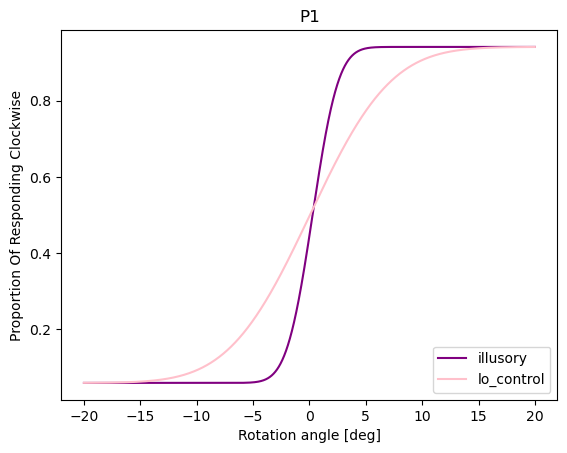

In [27]:
fig, ax = plt.subplots()
t = np.arange(-20, 20, 0.001)
s = kappa1 + (1 - 2 * kappa1) * norm.cdf(t, mu1, sigma1)
u = kappa1 + (1 - 2 * kappa1) * norm.cdf(t, mu2, sigma2)
# s = df.prop_fat
# t = np.arange(0.0, 2.0, 0.01)
# s = params_df.

ax.plot(t, s, color = "purple", label = "illusory")
ax.plot(t, u, color = "pink", label = "lo_control")
plt.legend(loc="lower right")
ax.set(xlabel = "Rotation angle [deg]", ylabel = "Proportion Of Responding Clockwise", title = "P1")
fig.savefig("fig.pdf")
plt.show()




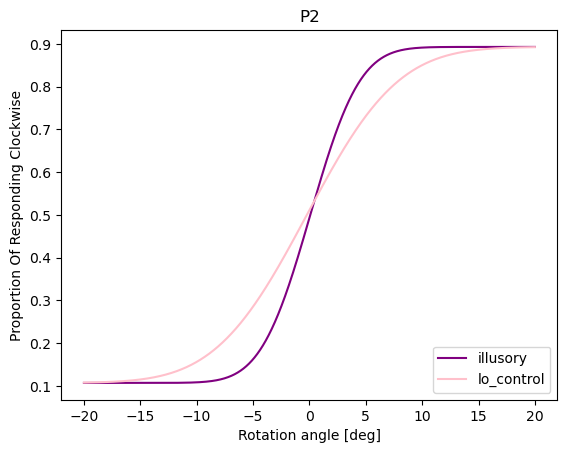

In [28]:
fig, ax = plt.subplots()
t = np.arange(-20, 20, 0.001)
s = kappa2 + (1 - 2 * kappa2) * norm.cdf(t, mu3, sigma3)
u = kappa2 + (1 - 2 * kappa2) * norm.cdf(t, mu4, sigma4)
# s = df.prop_fat
# t = np.arange(0.0, 2.0, 0.01)
# s = params_df.

ax.plot(t, s, color = "purple", label = "illusory")
ax.plot(t, u, color = "pink", label = "lo_control")
plt.legend(loc="lower right")
ax.set(xlabel = "Rotation angle [deg]", ylabel = "Proportion Of Responding Clockwise", title = "P2")
fig.savefig("fig2.pdf")
plt.show()

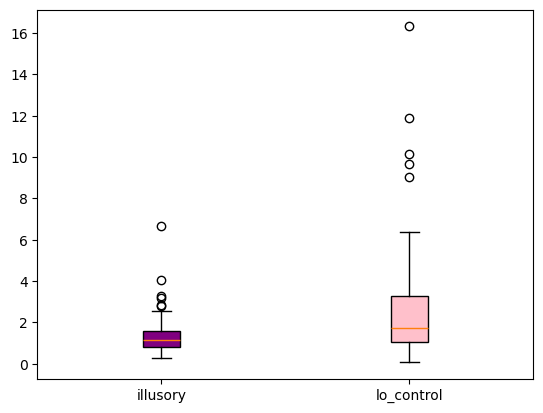

In [29]:
fig, ax = plt.subplots()

colors = ['purple', 'pink']
labels = ['illusory', 'lo_control']

bplot = ax.boxplot(jnds,
                    patch_artist=True,
                    labels = labels)

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

fig.savefig("boxplots_jnd.pdf")
plt.show()